<a href="https://colab.research.google.com/github/Anton-Ngan/CXR-Pneumonia-Image-Classification/blob/main/CXR_Pneumonia_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Chest X Ray Pneumonia Detection using Convolutional Neural Networks

In [55]:
# Import and install the required modules
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import zipfile
from torch import nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from pathlib import Path
from typing import Callable
from google.colab import files
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score

try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

try:
  from torchmetrics.classification import BinaryAccuracy, ConfusionMatrix
except:
  !pip install torchmetrics
  from torchmetrics.classification import BinaryAccuracy, ConfusionMatrix

In [2]:
# Device agnostic
device = "cuda" if torch.cuda.is_available() else "cpu"

## Download CXR dataset from Kaggle

* Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [3]:
!pip install kaggle

In [ ]:
# Upload the kaggle.json file from the Kaggle API
files.upload()

In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [6]:
# Change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:25<00:00, 171MB/s]
100% 2.29G/2.29G [00:25<00:00, 95.5MB/s]


## Retrieve and Visualise the CXR Dataset

In [8]:
data_dir = Path("data")

# Create a folder for the dataset
if data_dir.is_dir():
  print(f"{data_dir} folder already exists ... skipping download")
else:
  print(f"{data_dir} does not exist, creating one...")
  data_dir.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile("chest-xray-pneumonia.zip", "r") as zip_ref:
  print(f"Unzipping chest xray data...")
  zip_ref.extractall(data_dir)

data does not exist, creating one...
Unzipping chest xray data...


In [9]:
# Remove the unnecessary directories
!rm -r /content/data/chest_xray/__MACOSX
!rm -r /content/data/chest_xray/chest_xray

In [10]:
for dirpath, dirnames, filenames in os.walk(data_dir):
  print(f"Images: {len(filenames)} | Path: {dirpath}")

Images: 0 | Path: data
Images: 0 | Path: data/chest_xray
Images: 0 | Path: data/chest_xray/test
Images: 234 | Path: data/chest_xray/test/NORMAL
Images: 390 | Path: data/chest_xray/test/PNEUMONIA
Images: 0 | Path: data/chest_xray/train
Images: 1341 | Path: data/chest_xray/train/NORMAL
Images: 3875 | Path: data/chest_xray/train/PNEUMONIA
Images: 0 | Path: data/chest_xray/val
Images: 8 | Path: data/chest_xray/val/NORMAL
Images: 8 | Path: data/chest_xray/val/PNEUMONIA


In [11]:
train_dir = data_dir/ "chest_xray/train"
test_dir = data_dir/ "chest_xray/test"

train_dir, test_dir

(PosixPath('data/chest_xray/train'), PosixPath('data/chest_xray/test'))

Image Path: data/chest_xray/train/PNEUMONIA/person1185_bacteria_3133.jpeg
Image Class: PNEUMONIA | Width: 1160 | Height: 800


(-0.5, 1159.5, 799.5, -0.5)

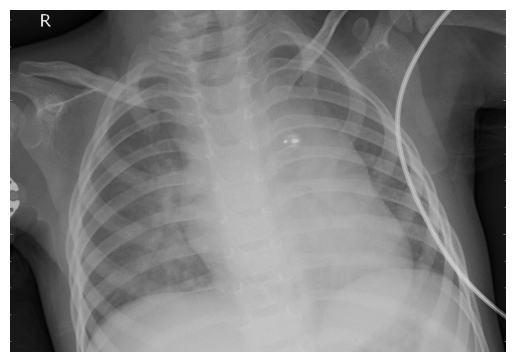

In [13]:
image_pth_lst = list(data_dir.glob("*/*/*/*.jpeg"))
rnd_image_pth = random.choice(image_pth_lst)
image_class = rnd_image_pth.parent.stem
img = Image.open(rnd_image_pth)

print(f"Image Path: {rnd_image_pth}")
print(f"Image Class: {image_class} | Width: {img.width} | Height: {img.height}")
plt.imshow(img, cmap="gray")
plt.axis(False)

(-0.5, 959.5, 463.5, -0.5)

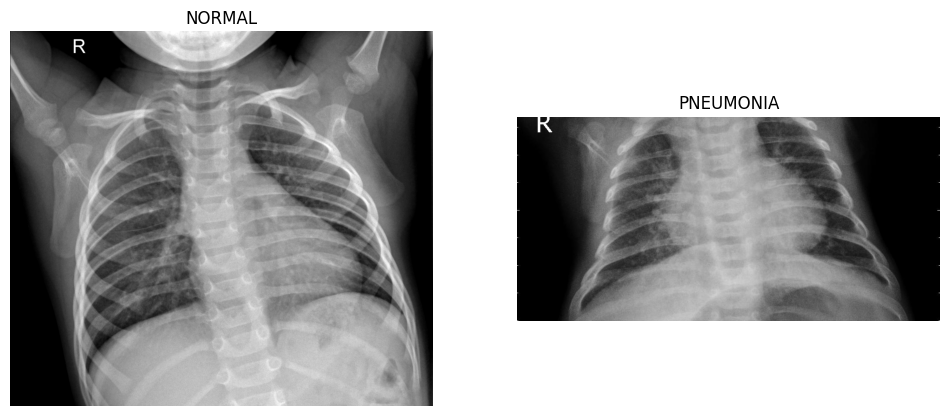

In [14]:
train_normal_path_lst = list(data_dir.glob("*/train/NORMAL/*.jpeg"))
train_pneumonia_path_lst = list(data_dir.glob("*/train/PNEUMONIA/*.jpeg"))

train_normal_path = random.choice(train_normal_path_lst)
train_pneumonia_path = random.choice(train_pneumonia_path_lst)
train_normal_img = Image.open(train_normal_path)
train_pneumonia_img = Image.open(train_pneumonia_path)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(train_normal_img, cmap="gray")
plt.title(train_normal_path.parent.stem)
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(train_pneumonia_img, cmap="gray")
plt.title(train_pneumonia_path.parent.stem)
plt.axis(False)

In [15]:
len(list(data_dir.glob("*/test/NORMAL/*.jpeg")))

234

Train Dataset:
     Classes  Count
0     Normal   1341
1  Pneumonia   3875

Test Dataset:
     Classes  Count
0     Normal    234
1  Pneumonia    390


[]

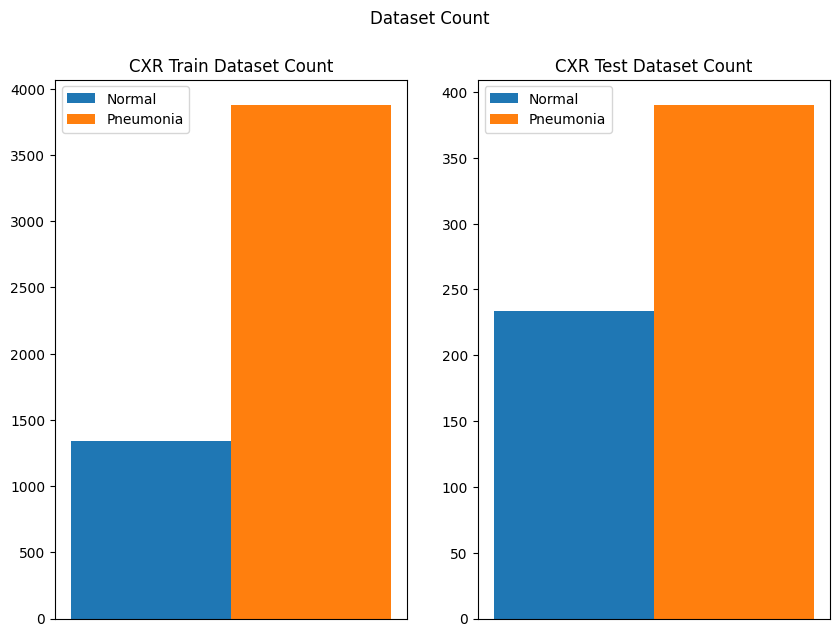

In [16]:
test_normal_len = len(list(data_dir.glob("*/test/NORMAL/*.jpeg")))
test_pneumonia_len = len(list(data_dir.glob("*/test/PNEUMONIA/*.jpeg")))

train_normal_dataset_len = len(train_normal_path_lst)
train_pneumonia_dataset_len = len(train_pneumonia_path_lst)

train_dataset = {
    "Classes": ["Normal", "Pneumonia"],
    "Count": [train_normal_dataset_len, train_pneumonia_dataset_len]
    }

test_dataset = {
    "Classes": ["Normal", "Pneumonia"],
    "Count": [test_normal_len, test_pneumonia_len]
}

train_df = pd.DataFrame(train_dataset)
print(f"Train Dataset:\n{train_df}\n")

test_df = pd.DataFrame(test_dataset)
print(f"Test Dataset:\n{test_df}")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7))
fig.suptitle("Dataset Count")
ax1.bar(1, train_normal_dataset_len, width=1.0, label="Normal")
ax1.bar(2, train_pneumonia_dataset_len, width=1.0, label="Pneumonia")
ax1.set_title("CXR Train Dataset Count")
ax1.legend()
ax2.bar(1, test_normal_len, width=1.0, label="Normal")
ax2.bar(2, test_pneumonia_len, width=1.0, label="Pneumonia")
ax2.set_title("CXR Test Dataset Count")
ax2.legend()
ax1.set_xticks([])
ax2.set_xticks([])


## Turn Data into Tensors and Dataloaders

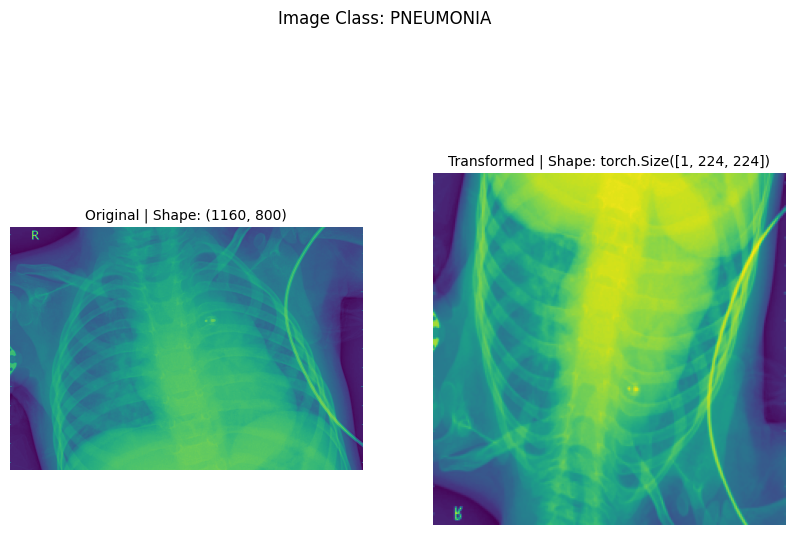

In [17]:
train_transform = transforms.Compose([
   transforms.Resize(size=(224, 224)),
   transforms.RandomHorizontalFlip(),
   transforms.RandomVerticalFlip(),
   transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

with Image.open(rnd_image_pth) as orig_img:
  img_t = train_transform(orig_img)

  plt.figure(figsize=(10, 7))
  plt.subplot(1, 2, 1)
  plt.imshow(orig_img)
  plt.title(f"Original | Shape: {orig_img.size}", fontsize=10)
  plt.axis(False)

  plt.subplot(1, 2, 2)
  plt.imshow(img_t.permute(1, 2, 0))   # [C, W, H] -> [W, H, C]
  plt.title(f"Transformed | Shape: {img_t.shape}", fontsize=10)
  plt.axis(False)

  plt.suptitle(f"Image Class: {rnd_image_pth.parent.stem}")

In [18]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 5216
     Root location: data/chest_xray/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 624
     Root location: data/chest_xray/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [19]:
train_data.classes

['NORMAL', 'PNEUMONIA']

In [20]:
len(train_data), len(test_data)

(5216, 624)

In [21]:
# Use class weighting to rectify the dataset imbalance
class_weights = []
for root, subdir, files in os.walk(train_dir):
    if len(files) > 0:
        class_weights.append(1/len(files))

sample_weights = [0] * len(train_data)
for idx, (image, label) in enumerate(train_data.imgs):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

sampler = WeightedRandomSampler(sample_weights,
                                num_samples=len(sample_weights),
                                replacement=True)

In [22]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")

Image tensor:
 tensor([[[0.0863, 0.0784, 0.0745,  ..., 0.3725, 0.3725, 0.3725],
         [0.0863, 0.0824, 0.0745,  ..., 0.3647, 0.3725, 0.3725],
         [0.0902, 0.0824, 0.0745,  ..., 0.3647, 0.3686, 0.3647],
         ...,
         [0.1176, 0.1137, 0.1098,  ..., 0.2353, 0.2353, 0.2353],
         [0.1373, 0.1373, 0.1333,  ..., 0.3176, 0.3216, 0.3216],
         [0.1765, 0.1765, 0.1765,  ..., 0.4196, 0.4235, 0.4235]],

        [[0.0863, 0.0784, 0.0745,  ..., 0.3725, 0.3725, 0.3725],
         [0.0863, 0.0824, 0.0745,  ..., 0.3647, 0.3725, 0.3725],
         [0.0902, 0.0824, 0.0745,  ..., 0.3647, 0.3686, 0.3647],
         ...,
         [0.1176, 0.1137, 0.1098,  ..., 0.2353, 0.2353, 0.2353],
         [0.1373, 0.1373, 0.1333,  ..., 0.3176, 0.3216, 0.3216],
         [0.1765, 0.1765, 0.1765,  ..., 0.4196, 0.4235, 0.4235]],

        [[0.0863, 0.0784, 0.0745,  ..., 0.3725, 0.3725, 0.3725],
         [0.0863, 0.0824, 0.0745,  ..., 0.3647, 0.3725, 0.3725],
         [0.0902, 0.0824, 0.0745,  ..., 0.3

In [23]:
# Turn train and test datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dl = DataLoader(dataset=train_data,
                      batch_size=BATCH_SIZE,
                      num_workers=NUM_WORKERS,
                      sampler=sampler)

test_dl = DataLoader(dataset=test_data,
                     batch_size=BATCH_SIZE,
                     num_workers=NUM_WORKERS,
                     shuffle=False)

train_dl, test_dl

(<torch.utils.data.dataloader.DataLoader at 0x79c3bff60b80>,
 <torch.utils.data.dataloader.DataLoader at 0x79c3bffc66b0>)

In [24]:
imgs, labels = next(iter(train_dl))

print(f"Image shape: {imgs.shape}")
print(f"Label shape: {labels.shape}")

Image shape: torch.Size([32, 3, 224, 224])
Label shape: torch.Size([32])


## Build CNN Model

In [25]:
class PneumoniaModel(nn.Module):

  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.cnn = nn.Sequential(

        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=4,
                  padding=2
                  ),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=4,
                  padding=2
                  ),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.MaxPool2d(kernel_size=3),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=4,
                  padding=2
                  ),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=4,
                  padding=2
                  ),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.MaxPool2d(kernel_size=3),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=4,
                  padding=2
                  ),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),

        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=4,
                  padding=2
                  ),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.MaxPool2d(kernel_size=3),

        nn.Dropout(p=0.5),
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*9*9,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.cnn(x)

In [26]:
CXRModel = PneumoniaModel(input_shape=3,
                          hidden_units=16,
                          output_shape=1
                          ).to(device)

CXRModel

PneumoniaModel(
  (cnn): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (8): ReLU()
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (11): ReLU()
    (12): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=(2, 

In [27]:
image_batch, label_batch = next(iter(train_dl))
image_batch.shape, label_batch.shape, image_batch[0].shape, len(image_batch)

(torch.Size([32, 3, 224, 224]),
 torch.Size([32]),
 torch.Size([3, 224, 224]),
 32)

In [28]:
CXRModel(image_batch.to(device))

tensor([[-1.0977],
        [-0.0593],
        [-0.8062],
        [-2.4405],
        [-2.5219],
        [-0.5145],
        [-0.6119],
        [-0.6110],
        [ 1.5209],
        [-3.4849],
        [ 0.4303],
        [ 1.2354],
        [-1.6115],
        [-0.6755],
        [-0.3443],
        [-1.7969],
        [ 0.1165],
        [-0.8482],
        [ 0.0818],
        [-0.9634],
        [-2.0865],
        [ 1.1212],
        [-0.5581],
        [ 0.9152],
        [-0.5105],
        [-1.7507],
        [-0.3512],
        [-1.8667],
        [-3.5887],
        [-0.1484],
        [-1.5531],
        [ 0.7750]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [29]:
summary(CXRModel, input_size=[1, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
PneumoniaModel                           [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Conv2d: 2-1                       [1, 16, 225, 225]         784
│    └─ReLU: 2-2                         [1, 16, 225, 225]         --
│    └─BatchNorm2d: 2-3                  [1, 16, 225, 225]         32
│    └─Conv2d: 2-4                       [1, 16, 226, 226]         4,112
│    └─ReLU: 2-5                         [1, 16, 226, 226]         --
│    └─BatchNorm2d: 2-6                  [1, 16, 226, 226]         32
│    └─MaxPool2d: 2-7                    [1, 16, 75, 75]           --
│    └─Conv2d: 2-8                       [1, 16, 76, 76]           4,112
│    └─ReLU: 2-9                         [1, 16, 76, 76]           --
│    └─BatchNorm2d: 2-10                 [1, 16, 76, 76]           32
│    └─Conv2d: 2-11                      [1, 16, 77, 77]           4,112
│    

## Create Training and Test Loop

In [30]:
accuracy = BinaryAccuracy().to(device)

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               accuracy_fn: Callable):
  model.train()
  train_loss, train_acc = 0, 0
  sample = 0

  for X, target in data_loader:
    X, target = X.to(device), target.to(device).type(torch.float)
    sample += len(X)

    y_pred = model(X).squeeze()
    y_label = torch.round(torch.sigmoid(y_pred))

    loss = loss_fn(y_pred, target)
    train_loss += loss
    train_acc += accuracy_fn(y_label, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if sample % 320 == 0:
      print(f"Train || Examined {sample}/{len(data_loader.dataset)}")

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  return train_loss, train_acc

In [31]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device,
              accuracy_fn: Callable):
  model.eval()
  test_loss, test_acc = 0, 0
  sample = 0

  with torch.inference_mode():
    for X, target in data_loader:
      X, target = X.to(device), target.to(device).type(torch.float)
      sample += len(X)

      y_pred = model(X).squeeze()
      y_label = torch.round(torch.sigmoid(y_pred))

      loss = loss_fn(y_pred, target)
      test_loss += loss
      test_acc += accuracy_fn(y_label, target)

      if sample % 64 == 0:
        print(f"Test || Examined {sample}/{len(data_loader.dataset)}")

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    return test_loss, test_acc

In [32]:
def train_model(model: torch.nn.Module,
                train_data_loader: torch.utils.data.DataLoader,
                test_data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                epochs: int,
                device: torch.device,
                accuracy_fn: Callable):

  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       data_loader=train_data_loader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device,
                                       accuracy_fn=accuracy_fn)
    test_loss, test_acc = test_step(model=model,
                                    data_loader=test_data_loader,
                                    loss_fn=loss_fn,
                                    device=device,
                                    accuracy_fn=accuracy_fn)

    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.5f} | Train accuracy: {train_acc*100:.2f}% | Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

### Select Optimizer and Loss Function

In [33]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=CXRModel.parameters(),
                            lr=0.01,
                            weight_decay=1e-2
                            )

## Train and Evaluate Model

The free version of Google Colab runs out of system RAM when training on this large dataset. So it is better to train the model in an IDE. The files to train the model are located here:
* https://github.com/Anton-Ngan/CXR-Pneumonia-Image-Classification

## Load the Model and Results

In [ ]:
# Upload the dictionary containing the model parameters,
# optimizer state dict, loss_fn and results
from google.colab import files
files.upload()

In [35]:
# Instantiate the model and optimizer
CXRModel = PneumoniaModel(input_shape=3,
                          hidden_units=16,
                          output_shape=1
                          ).to(device)
optimizer = torch.optim.SGD(params=CXRModel.parameters(),
                            lr=0.01,
                            weight_decay=1e-2
                            )

# Load the parameters and results
checkpoint = torch.load(Path("pneumonia_cxr_model.pth"), map_location=device)
CXRModel.load_state_dict(checkpoint["model_state_dict"])
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
loss_fn = checkpoint["loss"]
model_res = checkpoint["model_results"]
accuracy = BinaryAccuracy().to(device)

model_res

{'train_loss': [tensor(0.5200, device='cuda:0', requires_grad=True),
  tensor(0.2753, device='cuda:0', requires_grad=True),
  tensor(0.2320, device='cuda:0', requires_grad=True),
  tensor(0.2341, device='cuda:0', requires_grad=True)],
 'train_acc': [tensor(0.8081, device='cuda:0'),
  tensor(0.8970, device='cuda:0'),
  tensor(0.9107, device='cuda:0'),
  tensor(0.9126, device='cuda:0')],
 'test_loss': [tensor(0.6934, device='cuda:0'),
  tensor(0.3666, device='cuda:0'),
  tensor(0.3207, device='cuda:0'),
  tensor(0.4343, device='cuda:0'),
  tensor(0.3250, device='cuda:0')],
 'test_acc': [tensor(0.3656, device='cuda:0'),
  tensor(0.8516, device='cuda:0'),
  tensor(0.8813, device='cuda:0'),
  tensor(0.8531, device='cuda:0'),
  tensor(0.8672, device='cuda:0')]}

In [36]:
# Run inference using the model
test_loss, test_acc = test_step(model=CXRModel,
                                data_loader=test_dl,
                                loss_fn=loss_fn,
                                device=device,
                                accuracy_fn=accuracy
                                )
print(f"Epoch: n/a | Train loss: n/a | Train accuracy: n/a |Test loss: {test_loss:.5f} | Test accuracy: {test_acc*100:.2f}%")


Test || Examined 64/624
Test || Examined 128/624
Test || Examined 192/624
Test || Examined 256/624
Test || Examined 320/624
Test || Examined 384/624
Test || Examined 448/624
Test || Examined 512/624
Test || Examined 576/624
Epoch: n/a | Train loss: n/a | Train accuracy: n/a |Test loss: 0.32511 | Test accuracy: 86.56%


In [37]:
# The results array contain tensors, not ints
# array[tensors] -> array[int]
toInt = lambda t_arr : list(map(lambda t: t.item(), t_arr))

train_loss = toInt(model_res["train_loss"])
train_acc = toInt(model_res["train_acc"])
test_loss = toInt(model_res["test_loss"])
test_acc = toInt(model_res["test_acc"])

## Evaluate the Model

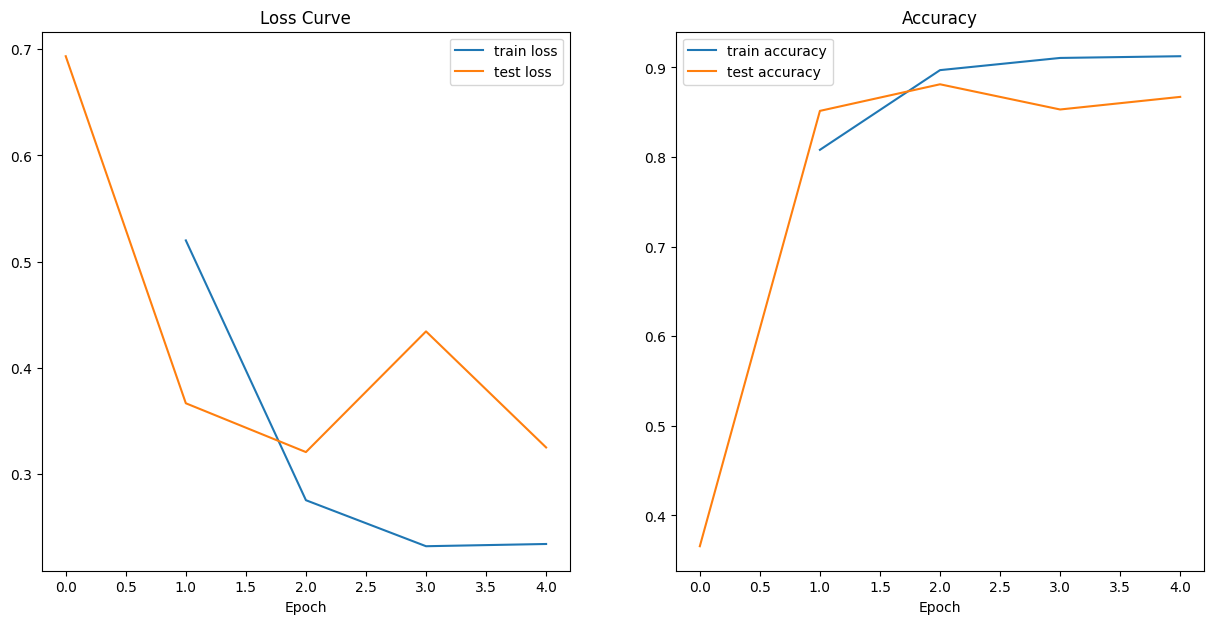

In [38]:
# Plot the loss curve and accuracy
epochs = range(len(train_loss))
plt.figure(figsize=(15,7))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss)+1), train_loss, label="train loss")
plt.plot(range(len(test_loss)), test_loss, label="test loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc)+1), train_acc, label="train accuracy")
plt.plot(range(len(test_acc)), test_acc, label="test accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.legend()

  0%|          | 0/20 [00:00<?, ?it/s]

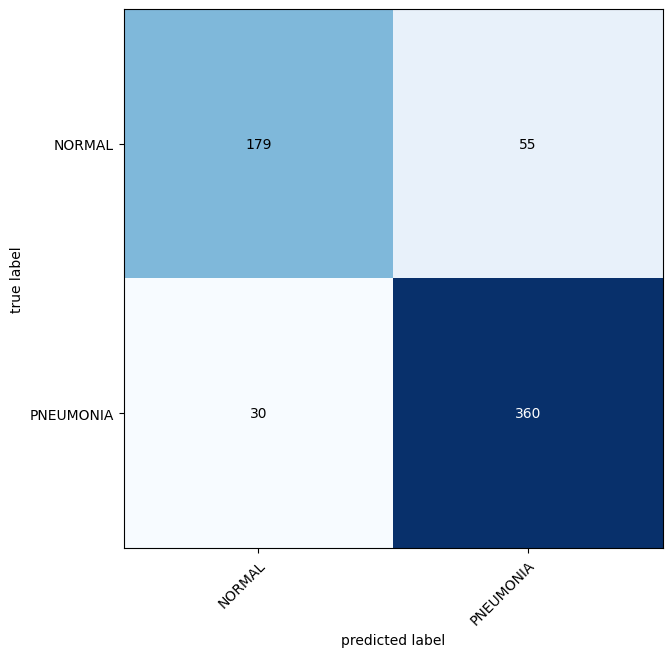

In [39]:
# Create the confusion matrix
# 1. Collect the predictions into the array
label_preds = []
CXRModel.eval()
with torch.inference_mode():
  for imgs, label in tqdm(test_dl):
    imgs, label = imgs.to(device), label.to(device)

    img_logit = CXRModel(imgs).squeeze()
    label_pred = torch.round(torch.sigmoid(img_logit))
    label_preds.append(label_pred.cpu())

label_preds_arr = torch.cat(label_preds)

# 2. Construct the confusion matrix
confmat = ConfusionMatrix(task="binary", num_classes=2)
confmat_tensor = confmat(preds=label_preds_arr,
                         target=torch.from_numpy(np.array(test_data.targets)).type(torch.float))

# 3. Plot the confusion matrix
plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=test_data.classes,
    figsize=(10, 7)
);

In [58]:
precision = precision_score(y_true=test_data.targets,
                            y_pred=label_preds_arr)
recall = recall_score(y_true=test_data.targets,
                      y_pred=label_preds_arr)
f1score = f1_score(y_true=test_data.targets,
                   y_pred=label_preds_arr)

print(f"Precision Score: {precision:.4f}\nRecall Score: {recall:.4f}\nF1 Score {f1score:.4f}")

Precision Score: 0.8675
Recall Score: 0.9231
F1 Score 0.8944
